# Introdução a biblioteca Keras

Neste notebook iremos praticar a sintaxe básica para treinar uma rede neural artificial utilizando as bibliotecas [Keras](https://www.tensorflow.org/api_docs/python/tf/keras/) e [Tensorflow](https://www.tensorflow.org/).

<br/><br/>
Embora nós iremos importar diretamente apenas objetos e funções da biblioteca Keras, a biblioteca tensorflow é necessária para que o treinamento das redes neurais seja feito.

Abaixo setamos as `seeds` para os geradores de números aleatórios para que possamos ter resultados reproduziveis.

In [ ]:
import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(42)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
tf.random.set_seed(42)

A biblioteca Keras possui diversos datasets pré-processados para facilitar a execução de testes. Além disso, essa disponibilização facilita o aprendizado de sua utilização.

## 1.Dataset

Abaixo iremos importar o dataset MNIST, o qual foi utilizado na semana passada com o notebook anterior. Note que o formato utilizado pela biblioteca Keras é diferente daquele utilizado por nós na última aula e, portanto, será feito um novo download do mesmo.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


O dataset MNSIT é um dataset clássico utilizado para avaliação de métodos de redes neurais há mais de 20 anos.

<br/>

Este dataset é composto de imagens digitalizadas de números de 0 a 9 e, portanto, possui 10 classes. Cada imagem digitalizada possui tamanho 28 pixels x 28 pixels e, portanto, possui 784 pixels no total. Desta forma, a entrada para rede neural terá 784 *features*.


<br/>

No total são 60.000 exemplos para treino e 10.000 exemplos para teste. Embora na prática evite-se utilizar uma partição fixa, esta divisão padrão nos permite comparar diretamente a performance de diversos algoritmos de *machine learning*.

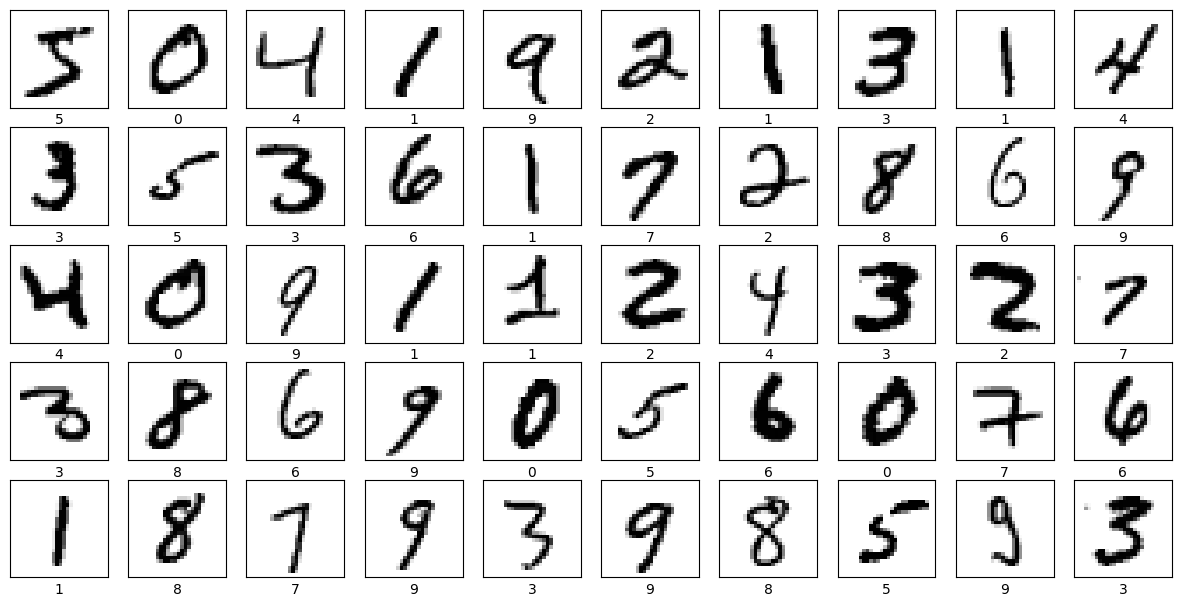

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
for i in range(50):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

### 1.1.Preparação do Dataset

A biblioteca Keras fornece algumas funções úteis para fazermos o pré-processamento dos datasets conforme a necessidade. Neste caso, iremos transformar os *targets* em classes para realizar classificações com a rede neural que iremos treinar.

In [ ]:
x_train = x_train.reshape(60000, 784)  ## reorganizando o dataset de treino em 60000 exemplos com 784 features cada
x_test = x_test.reshape(10000, 784)  ## reorganizando o dataset de teste em 60000 exemplos com 784 features cada
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print(f'{x_train.shape[0]} exemplos de treino')
print(f'{x_test.shape[0]} exemplos de teste')

class_names = [str(i) for i in range(10)]

num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes) ## transformando os targets do dataset de treino em classes
y_test = tf.keras.utils.to_categorical(y_test, num_classes)  ## transformando os targets do dataset de teste em classes

60000 exemplos de treino
10000 exemplos de teste


## 2.Modelagem

O modelo básico da biblioteca Keras é o modelo `Sequential`. Este modelo nos permite adicionar camadas na rede neural que serão processadas na sequência em que forem inseridas.

<br/>

Ao criarmos um objeto deste tipo, podemos adicionar as camadas utilizando o método `add` do modelo. Até o momento, vimos apenas as camadas básicas da rede neural e que são chamadas de camadas `Dense` pela biblioreca Keras.

###2.1 Arquitetura

Para cada camada adicionada devemos fornecer o número de neurônios da camada, sua função de ativação, a função de inicialização dos parâmetros $W$'s e dos parâmetros $b$'s, e ainda se desejamos utilizar ou não os parâmetros $b$'s. Note que para a primeira camada do modelo, devemos fornecer o parâmetro `input_shape` que indica o número de features que servirão como *input* para a rede neural. Note também que não há a camada de entrada que possui função de ativação identidade.

A assinatura da função está demonstrada abaixo. Para entender o que significam os parâmetros, consulte [aqui](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense).


```{python}
  tf.keras.layers.Dense(
      units,
      activation=None,
      use_bias=True,
      kernel_initializer='glorot_uniform',
      bias_initializer='zeros',
      kernel_regularizer=None,
      bias_regularizer=None,
      activity_regularizer=None,
      kernel_constraint=None,
      bias_constraint=None,
      **kwargs
  )
```

Note que para a a primeira camada, temos que definir qual é o `input_shape`, isto é, como será o formato de cada exemplo passado para a rede neural. Além disso, perceba que para a biblioteca `keras`, não existe o conceito de camada de entrada: ao passarmos o parâmetro `input_shape` na definição da camada, o modelo identifica que esta é a primeira camada da rede e executa de forma transparente a função identidade.

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(30, activation='sigmoid', input_shape=(784,)))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                23550     
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
Total params: 23860 (93.20 KB)
Trainable params: 23860 (93.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Antes de treinarmos o modelo, precisamos fazer sua compilação com o método `compile`. Isto utilizará a biblioteca tensorflow que fará diversas otimizações no código e irá gerar um executável na linguagem `C` (que não está imediatamente disponível para nós).

<br/>

Para compilar o código, precisamos passar qual a função de perda (`loss`), qual otimizador será utilizado para o treinamento (`optimizer`) e qual métrica será utilizada durante o treinamento para monitorarmos o progresso.

###2.2 Treino

A biblioteca keras oferece diversos otimizadores para treinamento. Para escolhermos, basta importar o otimizador desejado e fornecer para o método `compile`.

In [ ]:
# aqui utilizaremos a função categorical_crossentropy pois são mais de 2 classes e
# otimizador SGD enquanto monitoramos a evolução da acurácia para o modelo
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=20,
                    epochs=5,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]:.6f}')
print(f'Test accuracy: {score[1] * 100:.4f}%')

Epoch 1/5
3000/3000 [==============================] - 17s 5ms/step - loss: 1.3878 - accuracy: 0.7123 - val_loss: 0.8222 - val_accuracy: 0.8388
Epoch 2/5
3000/3000 [==============================] - 8s 3ms/step - loss: 0.6670 - accuracy: 0.8563 - val_loss: 0.5364 - val_accuracy: 0.8799
Epoch 3/5
3000/3000 [==============================] - 7s 2ms/step - loss: 0.4955 - accuracy: 0.8814 - val_loss: 0.4339 - val_accuracy: 0.8940
Epoch 4/5
3000/3000 [==============================] - 7s 2ms/step - loss: 0.4216 - accuracy: 0.8928 - val_loss: 0.3818 - val_accuracy: 0.9033
Epoch 5/5
3000/3000 [==============================] - 7s 2ms/step - loss: 0.3794 - accuracy: 0.8996 - val_loss: 0.3493 - val_accuracy: 0.9086
Test loss: 0.349296
Test accuracy: 90.8600%


##2.3 Visualizando treino

Abaixo temos um exemplo de como visualizar o treino do modelo. Há outras formas mais avançadas de visualizarmos o comportamento da rede durante o treino. Iremos nos aprofundar neste assunto em um dos próximos encontros.

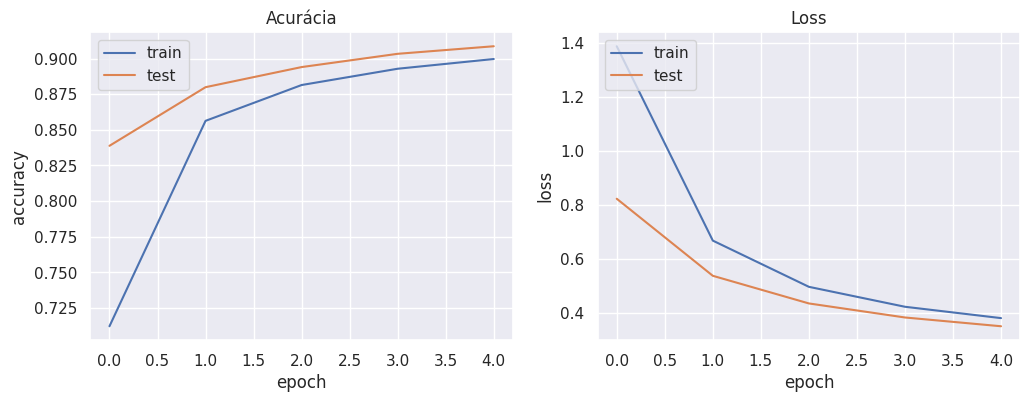

In [ ]:
import seaborn as sns
sns.set()
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# acurácia
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Acurácia')
ax1.set(xlabel='epoch', ylabel='accuracy')
ax1.legend(['train', 'test'], loc='upper left')

# loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Loss')
ax2.set(xlabel='epoch', ylabel='loss')
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

##3.Avaliação
A biblioteca Keras possui uma interface compatível com a biblioteca [scikit-learn](https://scikit-learn.org/stable/index.html), que é padrão para praticantes de *machine learning*. Por isso, podemos utilizar objetos e funções desta biblioteca para calcular métricas mais avançadas, como * precision*, * recall*  e * f1-score*.

<br/>

Note que a rede neural faz uma previsão do * score*  para cada classe possível para cada exemplo no dataset. Ou seja, para cada exemplo, a saída da rede neural será um *score* para cada classe possível. No nosso caso são 10 classes e por isso a saída da rede neural conterá 10 *scores* para cada exemplo.

<br/>

Em função desta saída em formato de scores, precisamos ober o score mais alto obtido para cada exemplo. Este * score*  irá nos dizer qual a classe foi prevista pela rede neural com um grau de confiança maior. Isso será obtido pela função `argmax` da biblioteca numpy

313/313 [==============================] - 2s 6ms/step
Acurácia: 90.8600%


Demais métricas (separadas por classe): 
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.95      0.98      0.97      1135
           2       0.90      0.88      0.89      1032
           3       0.90      0.89      0.90      1010
           4       0.90      0.92      0.91       982
           5       0.88      0.83      0.86       892
           6       0.93      0.93      0.93       958
           7       0.92      0.90      0.91      1028
           8       0.87      0.87      0.87       974
           9       0.88      0.89      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



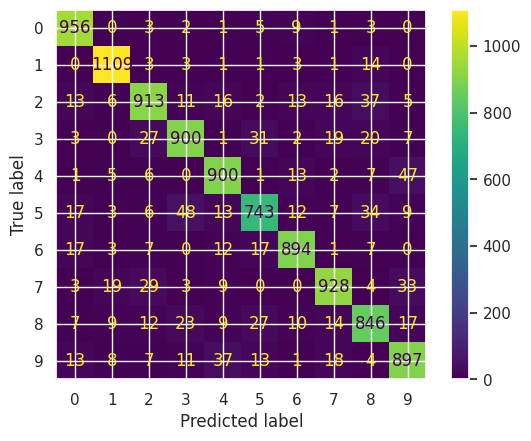

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

print(f'Acurácia: {accuracy_score(np.argmax(y_test, axis=1), y_pred) * 100:.4f}%')

print('\n\nDemais métricas (separadas por classe): ')
print(classification_report(np.argmax(y_test, axis=1), y_pred))